# BRIDGET: Compas

no duplicates ver


## Dataset Preprocessing


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import json
import yaml
import random
import time
import functools
import pickle
import re
import orjson
import alibi
import ignite
import copy

from IPython import display
from itertools import combinations, product
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optimizer

import fatf.utils.data.datasets as fatf_datasets
import fatf.fairness.data.measures as fatf_dfm
import fatf.utils.data.tools as fatf_data_tools

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import optim
from river import metrics
from river import feature_extraction, feature_selection
from river import ensemble, linear_model, forest, compose

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

from alibi.explainers.cfproto import CounterFactualProto

from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper
from b_xai_test import BRIDGET, HiC, MiC


In [7]:
def set_all_seeds(seed=42):
    
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
   
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except ImportError:
        pass

set_all_seeds(42)

In [8]:
data= pd.read_csv(r".\datasets\recidivism-risk_odsc.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14788 entries, 0 to 14787
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              14788 non-null  object
 1   age              14788 non-null  int64 
 2   race             14788 non-null  object
 3   juv_fel_count    14788 non-null  int64 
 4   juv_misd_count   14788 non-null  int64 
 5   juv_other_count  14788 non-null  int64 
 6   priors_count     14788 non-null  int64 
 7   c_charge_degree  14788 non-null  object
 8   compas_score     14788 non-null  int64 
 9   did_recid        14788 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 1.1+ MB


In [9]:
for c in data:
    print(data[c].value_counts().sum)

<bound method Series.sum of sex
Male      12093
Female     2695
Name: count, dtype: int64>
<bound method Series.sum of age
22    780
21    762
26    741
24    738
25    724
     ... 
96      2
78      1
83      1
80      1
79      1
Name: count, Length: 65, dtype: int64>
<bound method Series.sum of race
African-American    8004
Caucasian           4848
Hispanic            1083
Other                763
Asian                 57
Native American       33
Name: count, dtype: int64>
<bound method Series.sum of juv_fel_count
0     14176
1       390
2       135
3        46
4        19
5         9
8         4
10        4
6         3
20        1
13        1
Name: count, dtype: int64>
<bound method Series.sum of juv_misd_count
0     13854
1       643
2       174
3        57
4        23
8        11
6         9
5         8
12        4
7         3
13        2
Name: count, dtype: int64>
<bound method Series.sum of juv_other_count
0     13494
1       902
2       251
3        81
4        38
5         7

In [10]:
data['c_charge_degree'] = data['c_charge_degree'].str.strip("()")
data= data.drop(columns=['compas_score'])
data= data.drop_duplicates()

In [11]:
#  increasing order for gender, race
# will do severity of the charge order

gen_map= {'Female': 0, 'Male': 1}

race_map= { 'Native American': 0,
            'Asian': 1,
            'Other': 2,
            'Hispanic': 3,
            'Caucasian': 4,
            'African-American': 5         


}

# so F stands for Felony, M for Misdemeanor. Codes from Florida State Statues
# CO for County Ordinance, MO Municipal Ordinance, X/TCX non specified, NI0 Non infraction or sthm
# the last codes from the Broward County Statute, probably the least severe charges

charges_map= {
    'X': 0, 'TCX': 0, 'NI0': 0,    
    'MO3': 1, 'CO3': 1, 

    'M2': 2,   
    'M1': 3,  
    'F5': 4,                   
    'F6': 5,                       
    'F3': 6,  
    'F7': 7,  # apparently lvl 7 felonies can get u up to 15 years in prison                                   
    'F2': 8,                 
    'F1': 9

}

map_2= {
    'X': 0, 'TCX': 0, 'NI0': 0,    
    'MO3': 0, 'CO3': 0, 

    'M2': 1,   
    'M1': 2,  
    'F5': 3, 'F6': 3,'F3': 3,                    
                          
    
    'F7': 4, 'F2': 4, # apparently lvl 7 felonies can get u up to 15 years in prison                                   
                     
    'F1': 5

}


Felony offenses not listed in section 921.0022, Florida Statutes, are assigned a severity level in
accordance with section 921.0023, Florida Statutes, as follows:
(A) A felony of the third degree within offense level 1.
(B) A felony of the second degree within offense level 4.
(C) A felony of the first degree within offense level 7.
(D) A felony of the first degree punishable by life within offense level 9.
(E) A life felony within offense level 10

https://brycefetter.com/wp-content/uploads/2019/05/Offense-Severity-Chart.pdf

point system:
https://brycefetter.com/floridas-criminal-punishment-scoresheet/

So F1, F2 and F3 are the 3 degrees of Felony, while 5,6,7 are levels so it should go 5 --> 6--> 7 in increasing order of the severity of the offence

Encode: Gender, Race, c_charge_degree

Ordinal: juv_fel_count, juv_misd_count, juv_other_count, priors_count

Drop compas_score for now

Scaling w Standard Scaler

In [12]:
data['sex']= data['sex'].map(gen_map)
data['race']= data['race'].map(race_map)
data['c_charge_degree']= data['c_charge_degree'].map(map_2)

In [13]:
# Qui definiamo i vari split dei flussi 

data = data.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle iniziale

class_0 = data[data['did_recid'] == 0]
class_1= data[data['did_recid'] == 1]


def stratif(start_point, end_point):
    class_0_perc= class_0.iloc[int(len(class_0)*start_point) : int(len(class_0)*end_point)]
    class_1_perc= class_1.iloc[int(len(class_1)*start_point) : int(len(class_1)*end_point)]

    total= pd.concat([class_0_perc, class_1_perc]).sample(frac=1, random_state= 42).reset_index(drop=True)
    #chiaramente se c'è il concat bisogna rifare lo shuffle

    return total

In [14]:
#  split ufficiale

target= 'did_recid'
calibration_data= stratif(0.6, 0.8)
mic_data= stratif(0.8, 1.0)

avv_train= stratif(0.0, 0.07)
avv_test= stratif(0.07, 0.1)

hic_train= stratif(0.1, 0.5)
hic_test= stratif(0.5, 0.6)

print(len(calibration_data))
print(len(mic_data))

print(len(avv_train))
print(len(avv_test))

print(len(hic_train))
print(len(hic_test))

1083
1085
378
163
2167
541


In [15]:
categoricals= ['sex', 'race']
numericals= [c for c in data if c not in categoricals and c != target]


prepr_transf = (
    (compose.Select(*numericals, *categoricals) | preprocessing.StandardScaler()) 
)

In [16]:
## trasformazione in df perchè servono per il logging e come lookup delle istanze (batch1 e batch3)

df_batch_1 = pd.DataFrame(hic_train).reset_index(drop=True)

df_avv= pd.concat([avv_train, avv_test]).reset_index(drop=True)
df_avv.head(n=5)


,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,did_recid
0,1,22,5,0,1,0,3,3,1
1,1,23,5,0,0,0,3,4,1
2,0,28,5,0,0,0,10,1,1
3,1,40,5,0,0,0,0,5,0
4,0,48,4,0,0,0,0,3,0


In [17]:
## ora divisione in x e y

# avviamento 
X_avv_train = avv_train.drop(columns=[target])
y_avv_train = avv_train[target]

X_avv_test = avv_test.drop(columns=[target])
y_avv_test = avv_test[target]


# hic
X_hic_train = hic_train.drop(columns=[target])
y_hic_train = hic_train[target]

X_hic_test = hic_test.drop(columns=[target])
y_hic_test = hic_test[target]
# validation
X_val = calibration_data.drop(columns=[target])
y_val = calibration_data[target]

# mic
X_mic = mic_data.drop(columns=[target])
y_mic = mic_data[target]

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5417 entries, 0 to 5416
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   sex              5417 non-null   int64
 1   age              5417 non-null   int64
 2   race             5417 non-null   int64
 3   juv_fel_count    5417 non-null   int64
 4   juv_misd_count   5417 non-null   int64
 5   juv_other_count  5417 non-null   int64
 6   priors_count     5417 non-null   int64
 7   c_charge_degree  5417 non-null   int64
 8   did_recid        5417 non-null   int64
dtypes: int64(9)
memory usage: 381.0 KB


## Calibration Phase: Experts and Incremental Model Selection

In [19]:
with open(r".\experts_compas.yaml", "r") as f:
    config= yaml.safe_load(f)


params_dict= config['experts']['groups']['w_dict']



### Calibrating Incremental Model

The incremental model to be chosen for Bridget is trained on the X_avv, y_avv portion of the dataset,then evaluated on the X_avv_test and y_avv_test

The calibration phase starts by assessing the results of the learning for several configurations:

    - HoeffdingTreeClassifier

    - ExtremelyFastDecisionTreeClassifier

    - AdaBoostClassifier            (base= SGTClassifier)

    - AdwinBaggingClassifier        (base= SGTClassifier)

    - SRPClassifier                 (base= SGTClassifier)

    - AdaptiveRandomForestClassifier


The metrics observed are the Accuracy, the F1Score and the Counters for the classes

In [20]:
# since all River models work with dicts, lets first transform the dfs to dict
X_avv_df = pd.DataFrame(X_avv_train)
X_avv_test= pd.DataFrame(X_avv_test)

X_avv_dict= X_avv_df.to_dict(orient='records')
X_avv_dict_test= X_avv_test.to_dict(orient='records')


# setting the init params required by HIC class
RULE = False
PAST = True
SKEPT = True
GROUP = True
EVA=    True
N_BINS = 10
N_VAR = 3
MAX = 5

test_batch_1= pd.DataFrame(X_hic_test)

test_batch_1[target]= y_hic_test

rule_att = 'priors_count' #random rule
rule_value = -0.7

protected= ['race', 'age', 'sex']


In [21]:
# then the models are instantiated and trained by the HiC.train function
# the HiC object is initialized by passing a random user model, its not relevant since it won't interact with the IL anyways

expert= 'accurate_trusting'

base = tree.HoeffdingTreeClassifier(grace_period=100)

htree= tree.HoeffdingAdaptiveTreeClassifier(grace_period= 100)
efdt= tree.ExtremelyFastDecisionTreeClassifier(grace_period=100)
ada= ensemble.AdaBoostClassifier(model= base, n_models= 15, seed= 42)  
adwin= ensemble.ADWINBaggingClassifier(model= base, n_models= 15, seed= 42)
srp= ensemble.SRPClassifier(model= base, n_models=15, seed= 42)
arf= forest.ARFClassifier(n_models= 15, grace_period= 100, max_features='sqrt', seed=42)

models= [htree, efdt, ada, adwin, srp, arf]


for model in models:
    
    bridget_inst= hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, 'placeholder', model,
                warm_start_performance= 0,
                allocated_budget= 250,
                emergency_budget=50, 
                user_patience= 5,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= expert,
                df_batch1=df_batch_1, df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model='x', 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=prepr_transf
                    )

    
    bridget_inst.train(X_avv_dict, y_avv_train, X_avv_dict_test, y_avv_test)

trained_arf= arf

Accuracy: 61.35%
F1: 36.36%
Distribution of predictions: Counter({0: 131, 1: 32})
HoeffdingAdaptiveTreeClassifier trained
Accuracy: 63.19%
F1: 40.00%
Distribution of predictions: Counter({0: 130, 1: 33})
ExtremelyFastDecisionTreeClassifier trained
Accuracy: 60.12%
F1: 45.38%
Distribution of predictions: Counter({0: 111, 1: 52})
AdaBoostClassifier(HoeffdingTreeClassifier) trained
Accuracy: 61.35%
F1: 33.68%
Distribution of predictions: Counter({0: 135, 1: 28})
ADWINBaggingClassifier(HoeffdingTreeClassifier) trained
Accuracy: 61.35%
F1: 32.26%
Distribution of predictions: Counter({0: 137, 1: 26})
SRPClassifier(HoeffdingTreeClassifier) trained
Accuracy: 60.12%
F1: 41.44%
Distribution of predictions: Counter({0: 119, 1: 44})
ARFClassifier trained


### Calibrating Experts

For the Adult dataset the .search_bounds function was not capable to find the bounds at all, even after doubling the search range and running 10 iters

Thus i pre-trained the IL models first, which update the scaler, then transformed the columns for the expert to be fitted on

In [22]:
#expert_data= pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)

X_exp= X_hic_train.to_dict(orient='records')


X_exp_scaled= []

for x in X_exp:
    X_exp_scaled.append(prepr_transf.transform_one(x))

X_exp_final = pd.DataFrame(X_exp_scaled)

In [23]:
experts_obj= {}

expert_names = ['accurate_trusting', 'accurate_not_trusting', 
                'inaccurate_trusting', 'inaccurate_not_trusting']

 #enforcing order just to make sure the column transformer didnt shuffle the col order


for name in expert_names:
    expert_type= config['experts']['groups'][name]

    experts_obj[name]= BetaUser(
        belief_level= expert_type['belief_value'],
        rethink_level= 0.3,
        fairness= True,
        fpr= expert_type['target_FPR'],
        fnr= expert_type['target_FNR'],
        alpha= 0.9,
        
        features_dict= params_dict,
        seed= expert_type['group_seed']
        )
    res = experts_obj[name].fit(X_exp_final, y_hic_train, tol= 0.001)
    print(f"{'='*30}")
    print(f" EXPERT CALIBRATION REPORT ")
    print(f"{'='*30}")

    print(f"\n[EXPERT: {name}]")
    print(f"\n[FALSE POSITIVE RATE]")
    print(f"  - Iters:      {res['fpr iters number']}")
    print(f"  - Beta:       {res['calibrated_fpr_beta']:.4f}")
    print(f"  - Target:     {res['target_fpr']}")
    print(f"  - Achieved:   {res['achieved_fpr']:.4f}")

    print(f"\n[FALSE NEGATIVE RATE]")
    print(f"  - Iters:      {res['fnr iters number']}")
    print(f"  - Beta:       {res['calibrated_fnr_beta']:.4f}")
    print(f"  - Target:     {res['target_fnr']}")
    print(f"  - Achieved:   {res['achieved_fnr']:.4f}")
    


 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      11
  - Beta:       -3.4180
  - Target:     0.05
  - Achieved:   0.0501

[FALSE NEGATIVE RATE]
  - Iters:      11
  - Beta:       -3.0273
  - Target:     0.05
  - Achieved:   0.0495
 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      12
  - Beta:       -3.4668
  - Target:     0.05
  - Achieved:   0.0498

[FALSE NEGATIVE RATE]
  - Iters:      11
  - Beta:       -3.0273
  - Target:     0.05
  - Achieved:   0.0490
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      14
  - Beta:       -0.7690
  - Target:     0.3
  - Achieved:   0.3002

[FALSE NEGATIVE RATE]
  - Iters:      14
  - Beta:       -0.7690
  - Target:     0.3
  - Achieved:   0.2994
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      14
  - Beta:       -0.8179
  - Target:     0.3
  - Achieved:   

## BRIDGET decision making



### Expert: Accurate, Trusting 

#### HiC

In [21]:
clean_prepr = copy.deepcopy(prepr_transf)

arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_trusting']
name= f"{'accurate_trusting'}"
mod_name="ARF"



hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, mod_name, arf_mod,
                warm_start_performance= 60.12,
                allocated_budget= 400,
                emergency_budget=50, 
                user_patience= 5,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1, df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=prepr_transf
                    )

In [22]:
hic_df, _, equality, skept_count= hic_inst.start_HiC(df_avv)  

acc_t= pd.DataFrame(hic_df)

acc_t.to_csv(f".\processed_data\compas\hic_results_ds\hic_{name}", index=False)  

#5 min w ARF, skept 0.68, drift thresh= 0.85 (too low maybe?)


 18%|█▊        | 399/2167 [00:38<02:49, 10.44it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: HiC
Current desired perfomance: 63.126
Last 5 FEA values: [0.5996073559222478, 0.6036867512684787, 0.5975372556061133, 0.6016362046697887, 0.6056926582084442]


In [23]:
equality

[]

In [24]:
skept_count #none overcame the skept threshold set at 0.3

0

In [25]:
# before saving the calibration and batch 3 sets, i use the same river scaler to ensure the exact scale is applied

blueprint= pd.read_csv(r".\processed_data\compas\hic_results_ds\hic_accurate_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]] # ridefinisco l'ordering delle feats prima delle colonne informative 

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\compas\calibration_datasets\acc_t_calibration", index= False)


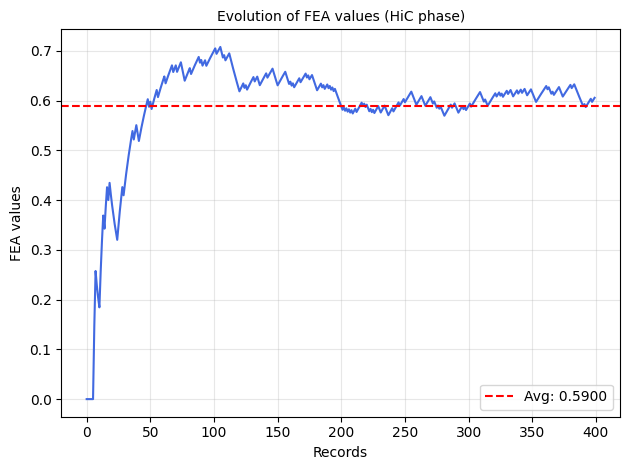

In [26]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

#### MiC

In [81]:
acc_t_switch= pd.read_csv(r".\processed_data\compas\switch_ds\acc_t_switch")
acc_t_switch = acc_t_switch.rename(columns={'g_truth':'did_recid'})

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=16, hidden_layer2=8, output_size=2, dropout_coeff= 0.0) 
mic_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [82]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= r".\nets\compas\acc_t_models\16_8_acc_t_model_36.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.57

In [83]:
acc_t_mic= MiC(mic_net, 'Def_Net', 
               benchmark_performance= 62,
                 user_patience= 200,
                 performance_delta= 0.05,
                 belief_threshold= 0.7,
                 tau_threshold= 0.57,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=clean_prepr
 )



acc_t_mic_df =acc_t_mic.start_MiC(X_stream, y_stream, acc_t_switch)   #3 minutes

  0%|          | 2/1085 [00:00<02:01,  8.94it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  0%|          | 4/1085 [00:00<01:42, 10.53it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  1%|          | 8/1085 [00:01<04:24,  4.07it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  1%|          | 10/1085 [00:02<03:48,  4.70it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  1%|          | 13/1085 [00:02<02:29,  7.18it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 17/1085 [00:03<02:26,  7.27it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 18/1085 [00:03<02:27,  7.23it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 19/1085 [00:04<05:39,  3.14it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 22/1085 [00:04<03:56,  4.50it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 24/1085 [00:05<03:44,  4.72it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 26/1085 [00:05<03:07,  5.65it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  3%|▎         | 29/1085 [00:05<02:21,  7.47it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  3%|▎         | 31/1085 [00:06<03:02,  5.78it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  3%|▎         | 34/1085 [00:06<02:03,  8.51it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  3%|▎         | 36/1085 [00:06<02:03,  8.52it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  3%|▎         | 37/1085 [00:06<02:07,  8.24it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▎         | 38/1085 [00:06<02:41,  6.49it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▍         | 41/1085 [00:07<02:22,  7.34it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▍         | 43/1085 [00:07<01:55,  9.02it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▍         | 46/1085 [00:07<02:15,  7.64it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▍         | 48/1085 [00:08<02:28,  7.01it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▍         | 51/1085 [00:09<03:45,  4.59it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▍         | 52/1085 [00:10<06:23,  2.69it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▍         | 54/1085 [00:10<06:04,  2.83it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▌         | 56/1085 [00:11<04:49,  3.55it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▌         | 57/1085 [00:11<04:06,  4.16it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▌         | 59/1085 [00:11<03:32,  4.82it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 60/1085 [00:11<03:59,  4.28it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 61/1085 [00:12<03:59,  4.28it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 63/1085 [00:12<04:40,  3.64it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 64/1085 [00:13<05:55,  2.87it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 66/1085 [00:13<04:15,  3.99it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 67/1085 [00:13<04:14,  4.00it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▋         | 69/1085 [00:14<03:36,  4.70it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  7%|▋         | 72/1085 [00:14<03:18,  5.11it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  7%|▋         | 73/1085 [00:14<03:01,  5.57it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  7%|▋         | 76/1085 [00:15<03:15,  5.16it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  7%|▋         | 79/1085 [00:15<01:58,  8.46it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  7%|▋         | 81/1085 [00:16<02:44,  6.11it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  8%|▊         | 83/1085 [00:17<04:46,  3.50it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  8%|▊         | 84/1085 [00:17<04:40,  3.57it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  8%|▊         | 86/1085 [00:18<04:17,  3.88it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  8%|▊         | 88/1085 [00:18<03:29,  4.75it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  8%|▊         | 90/1085 [00:18<03:16,  5.05it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  9%|▊         | 93/1085 [00:19<02:29,  6.65it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  9%|▉         | 96/1085 [00:19<02:19,  7.08it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  9%|▉         | 98/1085 [00:20<03:47,  4.34it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  9%|▉         | 101/1085 [00:20<03:02,  5.38it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  9%|▉         | 103/1085 [00:20<02:25,  6.77it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|▉         | 105/1085 [00:21<02:20,  6.96it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|▉         | 108/1085 [00:21<02:03,  7.91it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|█         | 109/1085 [00:21<02:31,  6.43it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|█         | 112/1085 [00:22<02:37,  6.18it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|█         | 113/1085 [00:22<03:39,  4.42it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 11%|█         | 117/1085 [00:23<02:15,  7.15it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 11%|█         | 119/1085 [00:23<02:08,  7.52it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 11%|█         | 120/1085 [00:23<02:25,  6.61it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 11%|█         | 122/1085 [00:23<02:20,  6.87it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 126/1085 [00:24<02:00,  7.95it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 128/1085 [00:24<02:16,  7.01it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 130/1085 [00:24<02:18,  6.90it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 132/1085 [00:25<02:10,  7.30it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 135/1085 [00:25<02:08,  7.37it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 13%|█▎        | 138/1085 [00:25<01:57,  8.06it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 13%|█▎        | 139/1085 [00:26<05:17,  2.98it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 13%|█▎        | 140/1085 [00:27<04:48,  3.28it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 13%|█▎        | 144/1085 [00:27<03:01,  5.18it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 13%|█▎        | 146/1085 [00:28<02:37,  5.96it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▎        | 148/1085 [00:28<02:21,  6.61it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▎        | 149/1085 [00:28<02:19,  6.73it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▍        | 151/1085 [00:28<02:41,  5.78it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▍        | 153/1085 [00:29<02:23,  6.51it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▍        | 155/1085 [00:29<02:10,  7.14it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▍        | 157/1085 [00:29<01:55,  8.01it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 15%|█▍        | 159/1085 [00:29<02:18,  6.67it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 15%|█▍        | 161/1085 [00:30<02:09,  7.15it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 15%|█▌        | 165/1085 [00:30<01:21, 11.29it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▌        | 169/1085 [00:30<01:26, 10.57it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▌        | 171/1085 [00:31<01:44,  8.75it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▌        | 174/1085 [00:32<04:18,  3.52it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▌        | 175/1085 [00:33<04:23,  3.45it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▌        | 176/1085 [00:33<04:09,  3.64it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▋        | 179/1085 [00:34<04:26,  3.39it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 17%|█▋        | 180/1085 [00:34<03:57,  3.81it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 17%|█▋        | 182/1085 [00:35<03:26,  4.37it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 17%|█▋        | 183/1085 [00:35<02:55,  5.13it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 17%|█▋        | 186/1085 [00:35<03:19,  4.50it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 17%|█▋        | 188/1085 [00:36<02:47,  5.37it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 18%|█▊        | 191/1085 [00:36<02:36,  5.72it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 18%|█▊        | 192/1085 [00:36<02:21,  6.30it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 18%|█▊        | 195/1085 [00:37<03:15,  4.56it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 18%|█▊        | 199/1085 [00:38<02:16,  6.49it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 18%|█▊        | 200/1085 [00:38<02:50,  5.20it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 

 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.5744634124721145, 0.56780913915148, 0.5728074895372497, 0.5777403126830886, 0.5826086444942916]


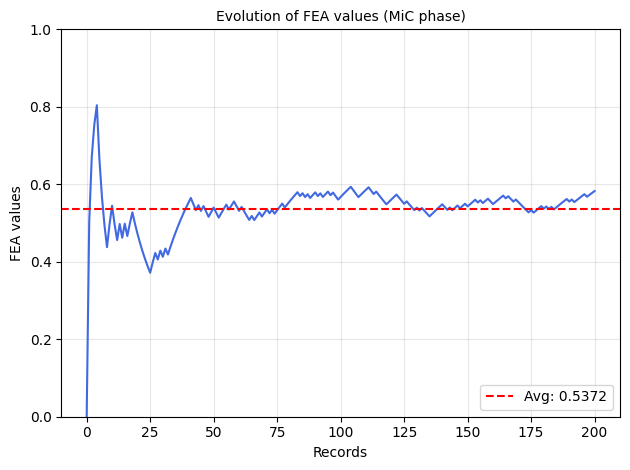

In [84]:
plt.plot(acc_t_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_t_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [85]:
acc_t_mic.deferred_decisions


79

In [ ]:
plt.plot(acc_t_mic.mach_confidence, linestyle='-', color='royalblue')

avg_conf= np.mean(acc_t_mic.mach_confidence)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


# RICORDATI DI AGGIUNGERLO AI SELF

AttributeError: 'MiC' object has no attribute 'mach_confidence'

##### Two Stage Deferral

Optimal tau= 0.57755

In [88]:
r_net_acc_t = DeferralNet(input_size=8, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.0)

r_net_acc_t.load_state_dict(torch.load(r'r_nets/compas/r_net_acc_t.pth'))
r_net_acc_t.to(device)
r_net_acc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [89]:
#36 min

acc_t_strat_2= MiC(mic_net, 'Def_Net', 
               benchmark_performance= 62,
                 user_patience= 200,
                 performance_delta= 0.05,
                 belief_threshold= 0.7,
                 tau_threshold= 0.57,
                 anqi_mao_thresh=0.57755, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=clean_prepr
 )



acc_t_df_2= acc_t_strat_2.start_MiC(X_stream, y_stream, acc_t_switch, r_net= r_net_acc_t, two_step_deferral=True)   #3 minutes

  0%|          | 2/1085 [00:00<01:56,  9.27it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  0%|          | 4/1085 [00:00<01:42, 10.54it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  1%|          | 8/1085 [00:01<04:10,  4.30it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  1%|          | 10/1085 [00:02<03:48,  4.71it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  1%|          | 13/1085 [00:02<02:28,  7.24it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  1%|▏         | 15/1085 [00:02<02:37,  6.78it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 18/1085 [00:03<02:24,  7.38it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 19/1085 [00:03<05:17,  3.36it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 22/1085 [00:04<03:37,  4.89it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 24/1085 [00:04<03:24,  5.18it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  2%|▏         | 26/1085 [00:04<02:52,  6.14it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  3%|▎         | 29/1085 [00:05<02:25,  7.26it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  3%|▎         | 31/1085 [00:05<03:19,  5.28it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  3%|▎         | 34/1085 [00:06<02:12,  7.94it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  3%|▎         | 37/1085 [00:06<02:23,  7.32it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▎         | 38/1085 [00:06<02:57,  5.89it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▍         | 41/1085 [00:07<02:37,  6.63it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▍         | 42/1085 [00:07<02:36,  6.68it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▍         | 44/1085 [00:07<02:17,  7.55it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▍         | 45/1085 [00:07<02:41,  6.44it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  4%|▍         | 48/1085 [00:08<02:35,  6.66it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▍         | 50/1085 [00:08<03:43,  4.63it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▍         | 51/1085 [00:09<03:42,  4.65it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▍         | 52/1085 [00:10<06:23,  2.69it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▍         | 54/1085 [00:10<06:08,  2.80it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▌         | 55/1085 [00:11<06:09,  2.79it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▌         | 58/1085 [00:11<03:52,  4.42it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  5%|▌         | 59/1085 [00:11<03:52,  4.41it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 60/1085 [00:12<04:05,  4.17it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 61/1085 [00:12<04:08,  4.12it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 63/1085 [00:12<04:40,  3.64it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 64/1085 [00:13<05:48,  2.93it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 66/1085 [00:13<04:15,  3.99it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▌         | 67/1085 [00:13<04:12,  4.03it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  6%|▋         | 69/1085 [00:14<03:39,  4.63it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  7%|▋         | 72/1085 [00:14<03:22,  5.00it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  7%|▋         | 73/1085 [00:14<03:04,  5.48it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  7%|▋         | 76/1085 [00:15<03:17,  5.10it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  7%|▋         | 79/1085 [00:15<02:01,  8.26it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  8%|▊         | 83/1085 [00:17<04:31,  3.68it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  8%|▊         | 84/1085 [00:17<04:22,  3.81it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  8%|▊         | 86/1085 [00:18<03:54,  4.26it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  8%|▊         | 88/1085 [00:18<03:10,  5.24it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  8%|▊         | 90/1085 [00:18<03:01,  5.50it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  9%|▊         | 93/1085 [00:18<02:16,  7.27it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  9%|▉         | 96/1085 [00:19<02:08,  7.68it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  9%|▉         | 98/1085 [00:20<03:26,  4.78it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  9%|▉         | 101/1085 [00:20<02:49,  5.81it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


  9%|▉         | 103/1085 [00:20<02:08,  7.67it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|▉         | 105/1085 [00:20<02:17,  7.13it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|▉         | 108/1085 [00:21<01:58,  8.22it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|█         | 109/1085 [00:21<02:11,  7.41it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|█         | 110/1085 [00:21<02:30,  6.48it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|█         | 112/1085 [00:22<02:44,  5.93it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 10%|█         | 113/1085 [00:22<03:53,  4.17it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 11%|█         | 117/1085 [00:22<02:24,  6.68it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 11%|█         | 118/1085 [00:22<02:21,  6.83it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 11%|█         | 120/1085 [00:23<02:12,  7.27it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 11%|█         | 122/1085 [00:23<02:07,  7.58it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 125/1085 [00:23<01:59,  8.03it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 127/1085 [00:24<02:02,  7.83it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 129/1085 [00:24<01:59,  8.03it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 130/1085 [00:24<01:59,  8.02it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 132/1085 [00:24<02:01,  7.83it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 12%|█▏        | 135/1085 [00:25<02:05,  7.58it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 13%|█▎        | 137/1085 [00:25<01:56,  8.10it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 13%|█▎        | 139/1085 [00:26<04:01,  3.91it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 13%|█▎        | 144/1085 [00:27<02:30,  6.23it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 13%|█▎        | 146/1085 [00:27<02:16,  6.90it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▎        | 148/1085 [00:27<02:12,  7.10it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▎        | 149/1085 [00:27<02:20,  6.66it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▍        | 151/1085 [00:28<02:43,  5.72it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▍        | 153/1085 [00:28<02:13,  6.97it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 14%|█▍        | 157/1085 [00:28<01:48,  8.59it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 15%|█▍        | 159/1085 [00:29<02:13,  6.95it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 15%|█▍        | 161/1085 [00:29<02:02,  7.55it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 15%|█▌        | 165/1085 [00:29<01:19, 11.54it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▌        | 169/1085 [00:30<01:18, 11.60it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▌        | 171/1085 [00:30<01:40,  9.11it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▌        | 173/1085 [00:32<05:08,  2.95it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▌        | 176/1085 [00:32<03:57,  3.82it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 16%|█▋        | 179/1085 [00:33<04:08,  3.65it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 17%|█▋        | 180/1085 [00:33<03:46,  3.99it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 17%|█▋        | 182/1085 [00:34<03:21,  4.48it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 17%|█▋        | 183/1085 [00:34<02:53,  5.21it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 17%|█▋        | 186/1085 [00:34<03:12,  4.66it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 17%|█▋        | 188/1085 [00:35<02:49,  5.28it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 18%|█▊        | 191/1085 [00:35<02:39,  5.62it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 18%|█▊        | 195/1085 [00:36<03:11,  4.64it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 18%|█▊        | 198/1085 [00:37<02:41,  5.49it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 


 18%|█▊        | 200/1085 [00:37<02:46,  5.32it/s]

GS fallito operands could not be broadcast together with shapes (8,) (2,) 
GS fallito operands could not be broadcast together with shapes (8,) (2,) 

 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.5744634124721145, 0.56780913915148, 0.5728074895372497, 0.5777403126830886, 0.5826086444942916]


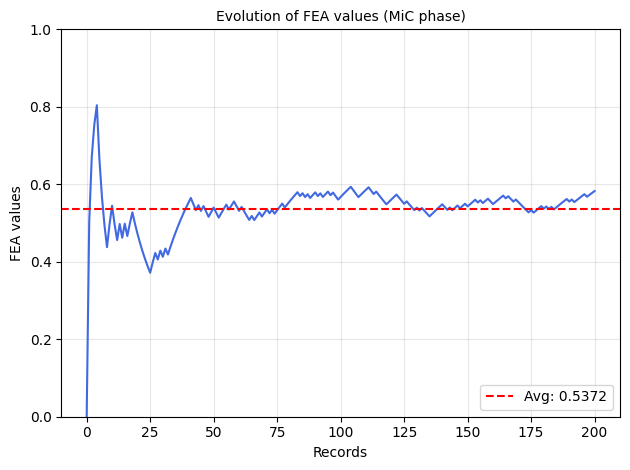

In [90]:
plt.plot(acc_t_strat_2.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_t_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [92]:
print(acc_t_strat_2.mic_acc)
print(acc_t_strat_2.model_acc)
acc_t_strat_2.deferred_decisions


0.5621890547263682
0.5621890547263682


1

In [93]:
acc_t_mic.stats

{False: {'user': {'tried': 49, 'got': 49, 'conf': 1},
  'machine': {'tried': 125, 'got': 71, 'conf': 0}},
 True: {'user': {'tried': 30, 'got': 30, 'conf': 1},
  'machine': {'tried': 76, 'got': 51, 'conf': 0}}}

In [94]:
acc_t_strat_2.stats

{False: {'user': {'tried': 0, 'got': 0, 'conf': 1},
  'machine': {'tried': 125, 'got': 125, 'conf': 0}},
 True: {'user': {'tried': 1, 'got': 1, 'conf': 1},
  'machine': {'tried': 76, 'got': 75, 'conf': 0}}}

#### HiC iter 2, Mic strat 1


previous best performance was 60.40

##### HiC 

In [ ]:
accuracies= pd.read_csv(r".\HIC_res\compas\results_accurate_trusting\HIC_DRIFT_User_accurate_trusting_ARFAccuracy.txt", sep=" ", header=None, names=["index", "accuracy"])

# Calcola la media della colonna accuracy
mean = accuracies["accuracy"].mean()
print(mean)

0.5981159443759413


In [183]:
#retrieving the trained model

file_path = r"HIC_res\compas\results_accurate_trusting\HIC_DRIFT_User_accurate_trusting_ARFmodel.pkl"

with open(file_path, "rb") as f:
    prev_arf = pickle.load(f)

In [184]:
hic_iter_2= pd.read_csv(r".\processed_data\compas\drift_checkpoints\MiC_accurate_trusting_Confidence")
hic_iter_2= hic_iter_2.drop(columns=["expert prediction", "machine prediction", "ground truth", "proba_model", "provider"])


In [185]:
# ora devo sostituire i record del df originale con questi qua

hic_2= get_new_df(df_batch_1, hic_iter_2)
hic_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   juv_fel_count    2167 non-null   float64
 1   juv_other_count  2167 non-null   float64
 2   c_charge_degree  2167 non-null   float64
 3   priors_count     2167 non-null   float64
 4   age              2167 non-null   float64
 5   juv_misd_count   2167 non-null   float64
 6   sex              2167 non-null   float64
 7   race             2167 non-null   float64
 8   did_recid        2167 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 152.5 KB


In [24]:
clean_prepr = copy.deepcopy(prepr_transf)

arf_mod= copy.deepcopy(prev_arf)

current_expert= experts_obj['accurate_trusting']
name= f"{'accurate_trusting'}"
mod_name="ARF"



hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, mod_name, arf_mod,
                warm_start_performance= 60.40,
                allocated_budget= 1200,
                emergency_budget=50, 
                user_patience= 5,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=hic_2, df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=prepr_transf
                    )

NameError: name 'prev_arf' is not defined

In [191]:
hic_df, _, equality, skept_count= hic_inst.start_HiC(df_avv)  

acc_t= pd.DataFrame(hic_df)
hic_iter= 2

path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

acc_t.to_csv(file_path, index=False)



 55%|█████▌    | 1199/2167 [03:29<02:49,  5.73it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: HiC
Current desired perfomance: 63.42
Last 5 FEA values: [0.5601910829061916, 0.5645891982948275, 0.5689433320078416, 0.5732539238723731, 0.5775214093170825]


In [192]:
equality

[]

In [193]:
skept_count #none overcame the skept threshold set at 0.3

0

In [27]:
# before saving the calibration and batch 3 sets, i use the same river scaler to ensure the exact scale is applied
hic_iter= 2
blueprint= pd.read_csv(r".\processed_data\compas\hic_results_ds\hic_accurate_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]] # ridefinisco l'ordering delle feats prima delle colonne informative 

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]

path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_t_calibration.csv")
df_calibration.to_csv(file_path, index=False)



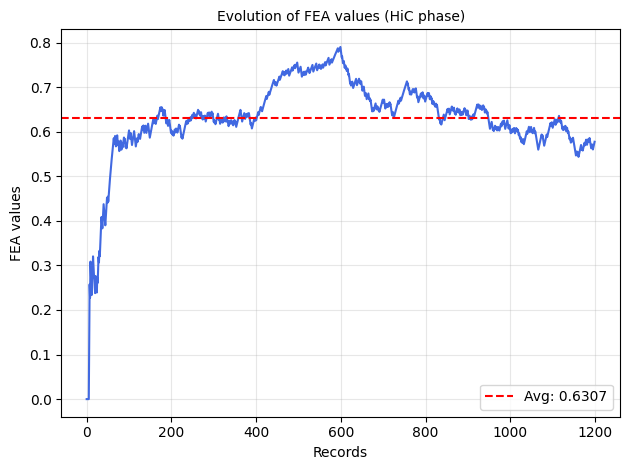

In [194]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC Conf

### Expert: Inaccurate, Trusting 

In [26]:
def scale_df(data, pipe, target_c):  # a quanto pare usando questa pipeline di River la label viene persa per strada quindi la devo riattaccarre
    processed_r= []
    labels= data[target_c].values
    X = data.drop(columns=[target_c])

    for i,r in enumerate(X.to_dict(orient='records')):
        scaled_r = pipe.transform_one(r)
        scaled_r[target_c] = labels[i]
        processed_r.append(scaled_r)
    return pd.DataFrame(processed_r)

#### HiC

In [27]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['inaccurate_trusting']
name= f"{'inaccurate_trusting'}"
   

hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, current_expert, protected, categoricals, numericals,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, arf_mod,  
                0.85, 0.7, 0.0, prepr_transf) 


In [28]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

inacc_t_hic= pd.DataFrame(hic_df)

inacc_t_hic.to_csv(f".\processed_data\compas\hic_results_ds\hic_{name}", index=False)  # 43 min

100%|██████████| 2167/2167 [00:33<00:00, 64.99it/s] 


In [29]:
eval_res

[[0, 0.0, 0, 0, 0.6136783733826248, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0,
  0.6534653465346535,
  0,
  0,
  0.6081330868761553,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  71,
  30],
 [0,
  0.6417910447761194,
  0,
  0,
  0.6155268022181146,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  128,
  73],
 [0,
  0.627906976744186,
  0,
  0,
  0.6136783733826248,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  194,
  107],
 [0,
  0.6458852867830424,
  0,
  0,
  0.6192236598890942,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  255,
  146],
 [0,
  0.6307385229540918,
  0,
  0,
  0.5711645101663586,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  322,
  179],
 [0,
  0.632279534109817,
  0,
  0,
  0.6136783733826248,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  391,
  210],
 [0,
  0.6291012838801712,
  0,
  0,
  0.6136783733826248,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  458,
  243],
 [0,
  0.6416978776529338,
  0,
  0,
  0.6266173752310537,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  523,
  278],
 [0,
  0.6514983351831298,
  0,
  0,
  0.600739371534196,
  0,
  0,
 

In [30]:
blueprint= pd.read_csv(r".\processed_data\compas\hic_results_ds\hic_inaccurate_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\compas\calibration_datasets\inacc_t_calibration", index= False)

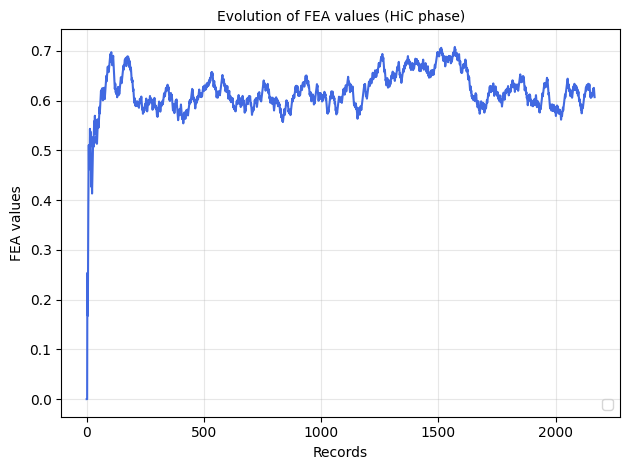

In [31]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### MiC


In [54]:
inacc_t_switch= pd.read_csv(r".\processed_data\compas\switch_ds\inacc_t_switch")
inacc_t_switch = inacc_t_switch.rename(columns={'g_truth':'did_recid'})

In [55]:
mic_net = DeferralNet(input_size=8, hidden_layer1=16, hidden_layer2=8, output_size=2,dropout_coeff= 0.2) 
mic_net.to(device)

X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= r"nets\compas\inacc_t_models\16_8_model_30.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Confidence-based Deferral
Tau = 0.5700000000000001

In [56]:
inacc_t_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.5700000000000001, clean_prepr)


inacc_t_mic_df, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=inacc_t_mic.start_MiC(X_stream, y_stream, inacc_t_switch)   #3 minutes


 46%|████▋     | 502/1085 [00:00<00:00, 1402.33it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.5287511787907335, 0.5334948351162722, 0.538190430572123, 0.5428384583120777, 0.5373752439172534]


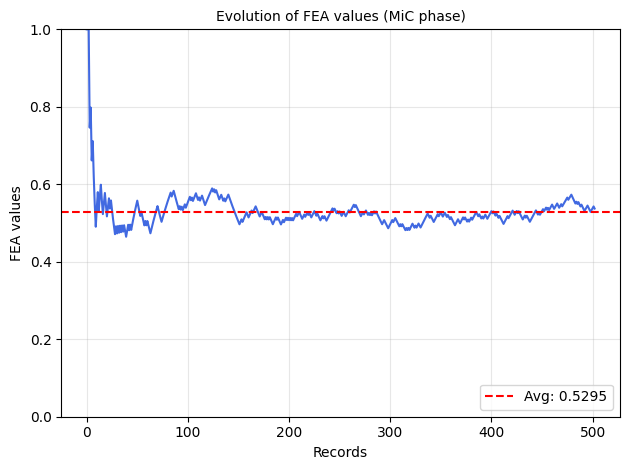

In [57]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [58]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
inacc_t_mic.deferred_decisions

0.5666003976143141
0.5268389662027833


117

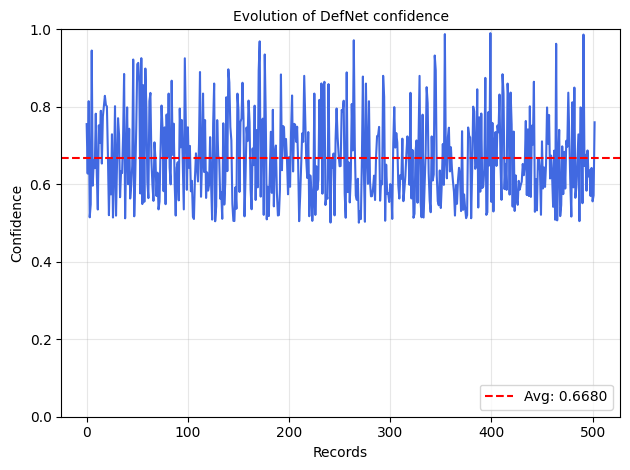

In [59]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

thresh= 0.183673

In [60]:
r_net_inacc_t = DeferralNet(input_size=8, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.2)

r_net_inacc_t.load_state_dict(torch.load(r'r_nets\compas\r_net_inacc_t.pth'))
r_net_inacc_t.to(device)
r_net_inacc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [61]:
inacc_t_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.57, clean_prepr, 0.183673)
 


inacc_t_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=inacc_t_strat_2.start_MiC(X_stream, y_stream, inacc_t_switch, r_net_inacc_t, two_step_deferral=True)   #3 minutes


 46%|████▋     | 502/1085 [00:00<00:00, 1085.73it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.5287511787907335, 0.5334948351162722, 0.538190430572123, 0.5428384583120777, 0.5373752439172534]


In [62]:
print(mic_acc_3)
print(model_acc_3)
inacc_t_strat_2.deferred_decisions


0.5705765407554672
0.5268389662027833


90

### Expert: Accurate, Not Trusting

#### HIC

In [32]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_not_trusting']
name= f"{'accurate_not_trusting'}"

hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, current_expert, protected, categoricals, numericals,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, arf_mod,  
                0.85, 0.7, 0.0, prepr_transf) 


In [33]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

hic_df= pd.DataFrame(hic_df)

hic_df.to_csv(f".\processed_data\compas\hic_results_ds\hic_{name}", index=False)  # 60 minuti

100%|██████████| 2167/2167 [00:33<00:00, 64.94it/s] 


In [34]:
blueprint= pd.read_csv(r".\processed_data\compas\hic_results_ds\hic_accurate_not_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\compas\calibration_datasets\acc_nt_calibration", index= False)


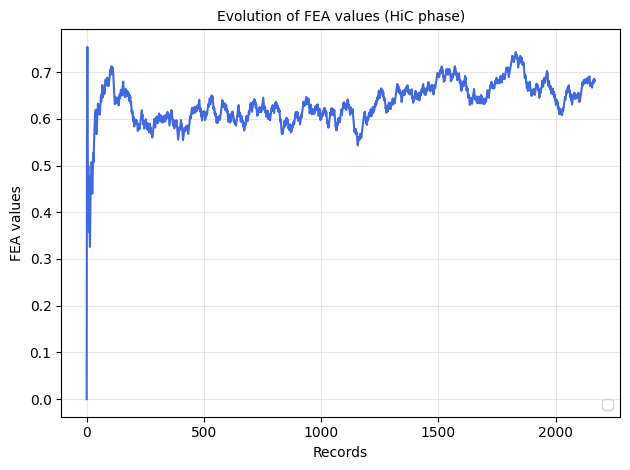

In [35]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
print(np.average(hic_feas))

0.6329289833976928


#### MIC

In [63]:
acc_nt_switch= pd.read_csv(r".\processed_data\compas\switch_ds\acc_nt_switch")
acc_nt_switch = acc_nt_switch.rename(columns={'g_truth':'did_recid'})


In [65]:
mic_net = DeferralNet(input_size=8, hidden_layer1=16, hidden_layer2=8, output_size=2, dropout_coeff= 0.2) 

X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= r"nets\compas\acc_nt_models\16_8_acc_nt_model_30.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Confidence Based Deferral

Tau = 0.64

In [66]:
acc_nt_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.64, clean_prepr)


acc_nt_mic_df, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=acc_nt_mic.start_MiC(X_stream, y_stream, acc_nt_switch)   #3 minutes


 47%|████▋     | 505/1085 [00:00<00:00, 1600.46it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.6319014164928597, 0.635606020412014, 0.6292095886182285, 0.6329408071164951, 0.6366342465856405]


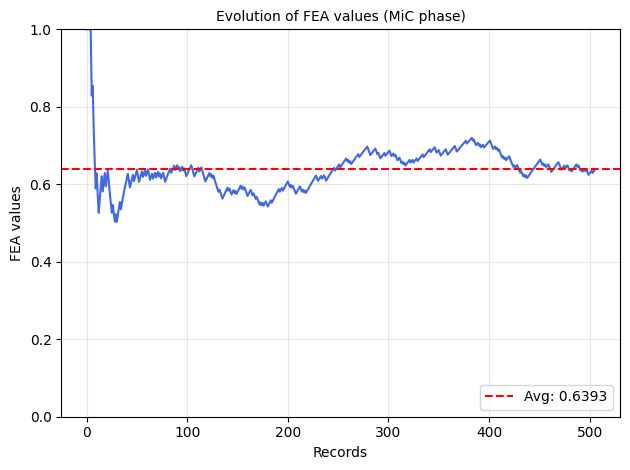

In [67]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [68]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
acc_nt_mic.deferred_decisions

0.6679841897233202
0.6403162055335968


162

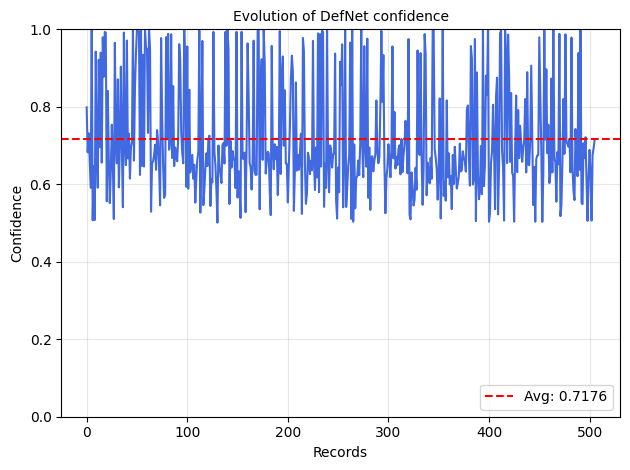

In [69]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

threshold= 0.181633

In [70]:
r_net_acc_nt = DeferralNet(input_size=8, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.2)

r_net_acc_nt.load_state_dict(torch.load(r'r_nets\compas\r_net_acc_nt.pth'))
r_net_acc_nt.to(device)
r_net_acc_nt.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [71]:
acc_nt_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.64, clean_prepr,0.181633 ) 


acc_nt_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=acc_nt_strat_2.start_MiC(X_stream, y_stream, acc_nt_switch, r_net_acc_nt, two_step_deferral=True)   #3 minutes


 47%|████▋     | 505/1085 [00:00<00:00, 1200.61it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.6319014164928597, 0.635606020412014, 0.6292095886182285, 0.6329408071164951, 0.6366342465856405]


In [72]:
print(mic_acc_3)
print(model_acc_3)
acc_nt_strat_2.deferred_decisions


0.6818181818181818
0.6403162055335968


159

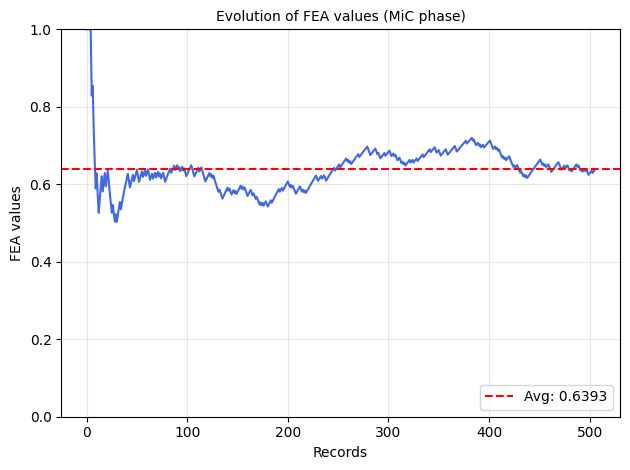

In [73]:
plt.plot(fea_mic_3, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_3)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


### Expert: Inaccurate, Not Trusting

#### HIC

In [37]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['inaccurate_not_trusting']
name= f"{'inaccurate_not_trusting'}"


hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, current_expert, protected, categoricals, numericals,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, arf_mod,  
                0.85, 0.7, 0.0, prepr_transf) 


In [38]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

hic_df= pd.DataFrame(hic_df)

hic_df.to_csv(f".\processed_data\compas\hic_results_ds\hic_{name}", index=False)  # 40 minuti

100%|██████████| 2167/2167 [00:34<00:00, 63.66it/s] 


In [39]:
blueprint= pd.read_csv(r".\processed_data\compas\hic_results_ds\hic_inaccurate_not_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\compas\calibration_datasets\inacc_nt_calibration", index= False)


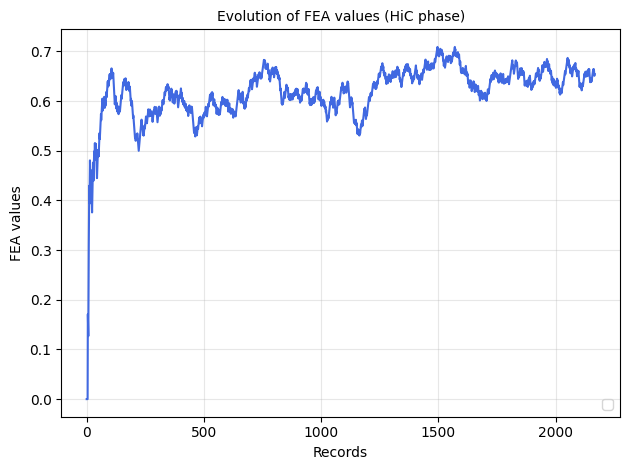

In [40]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### MIC

In [74]:
inacc_nt_switch= pd.read_csv(r".\processed_data\compas\switch_ds\inacc_nt_switch")
inacc_nt_switch = inacc_nt_switch.rename(columns={'g_truth':'did_recid'})


In [75]:
mic_net = DeferralNet(input_size=8, hidden_layer1=16, hidden_layer2=8, output_size=2,dropout_coeff= 0.2) 
mic_net.to(device)

X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= r"nets\compas\inacc_nt_models\16_8_inacc_nt_model_11.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Deferral Strat 1

tau= 0.52


In [76]:
inacc_nt_mic_strat_1= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.52, clean_prepr)


inacc_nt_mic, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=inacc_nt_mic_strat_1.start_MiC(X_stream, y_stream, inacc_nt_switch)   #3 minutes


 46%|████▋     | 503/1085 [00:00<00:00, 1604.17it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.5498132306216226, 0.5543445736971149, 0.558830012979985, 0.5532058569821487, 0.5476386606081823]


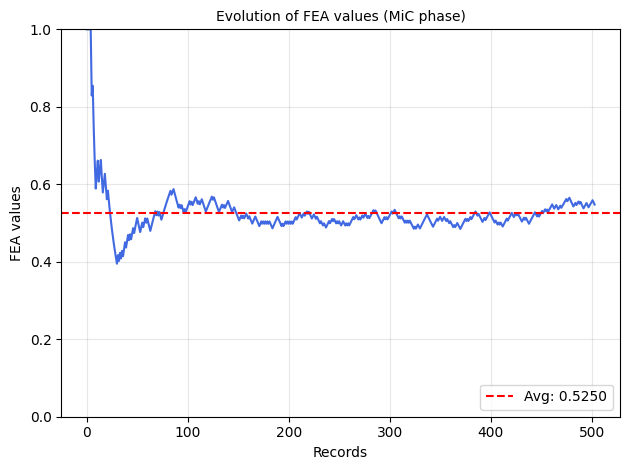

In [77]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [78]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
inacc_nt_mic_strat_1.deferred_decisions

0.5694444444444444
0.5238095238095238


94

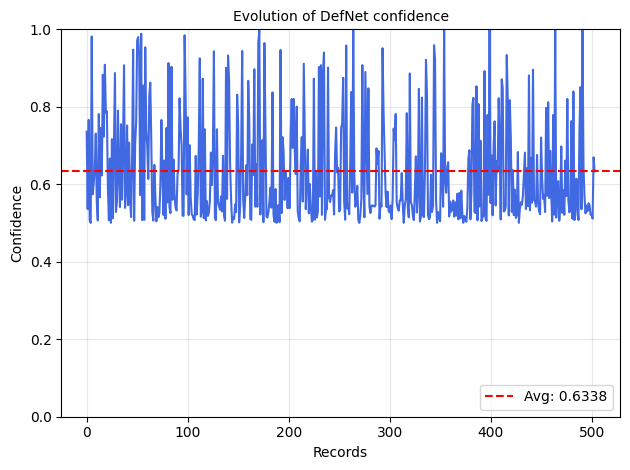

In [79]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Deferral Strat 2

anqi mao thresh= 0.179592

In [87]:
r_net_inacc_nt = DeferralNet(input_size=8, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.2)

r_net_inacc_nt.load_state_dict(torch.load(r'r_nets\compas\r_net_inacc_nt.pth'))
r_net_inacc_nt.to(device)
r_net_inacc_nt.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [88]:
inacc_nt_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, current_expert, protected,
               categoricals, numericals, mic_net, 0.8, 0.7, 0.52, clean_prepr, 0.179592)


inacc_nt_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=inacc_nt_strat_2.start_MiC(X_stream, y_stream, acc_nt_switch, r_net_acc_nt, two_step_deferral=True)   #3 minutes


 46%|████▋     | 503/1085 [00:00<00:00, 1132.37it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.5498132306216226, 0.5543445736971149, 0.558830012979985, 0.5532058569821487, 0.5476386606081823]


In [89]:
print(mic_acc_3)
print(model_acc_3)
inacc_nt_strat_2.deferred_decisions


0.5694444444444444
0.5238095238095238


173